In [1]:
import numpy as np

In [2]:
from scipy.io import loadmat
from scipy.linalg import expm, logm

In [3]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data_path = '/Users/linggeli/neuroscience/data/SuperChris/super_chris_extraction_odor2s.mat'
data_odor = loadmat(data_path)

In [5]:
trial_info = data_odor['trialInfo']

In [6]:
select_odor_B = (trial_info[:, 0] == 1) & (trial_info[:, 1] == 1) & (trial_info[:, 3] == 2)
select_odor_C = (trial_info[:, 0] == 1) & (trial_info[:, 1] == 1) & (trial_info[:, 3] == 3)

In [7]:
lfp_odor_B = data_odor['lfpEpoch'][select_odor_B, 2000:4000, 5:10]
lfp_odor_C = data_odor['lfpEpoch'][select_odor_C, 2000:4000, 5:10]

In [8]:
print(lfp_odor_B.shape)
print(lfp_odor_C.shape)

(41, 2000, 5)
(37, 2000, 5)


In [9]:
cov_series_odor_B = np.zeros((20, 50, 5, 5))  
utv_series_odor_B = np.zeros((20, 50, 15))  
for i in range(20):
    for t in range(50):
        lfp_window = lfp_odor_B[i, (t * 10):(t * 10 + 50), :]
        cov = np.cov(lfp_window, rowvar=False)
        cov_series_odor_B[i, t, :, :] = cov
        utv = logm(cov)[np.triu_indices(5)]
        utv_series_odor_B[i, t, :] = utv

In [10]:
cov_series_odor_C = np.zeros((20, 50, 5, 5)) 
utv_series_odor_C = np.zeros((20, 50, 15)) 
for i in range(20):
    for t in range(50):
        lfp_window = lfp_odor_C[i, (t * 10):(t * 10 + 50), :]
        cov = np.cov(lfp_window, rowvar=False)
        cov_series_odor_C[i, t, :, :] = cov
        utv = logm(cov)[np.triu_indices(5)]
        utv_series_odor_C[i, t, :] = utv

In [11]:
all_vector = np.concatenate([utv_series_odor_B, utv_series_odor_C]).reshape((2000, 15))
Y = all_vector - np.mean(all_vector, axis=0)
print(Y.shape)

(2000, 15)


In [40]:
from sklearn.decomposition import PCA

In [41]:
pca = PCA(n_components=2)
components = pca.fit_transform(Y)

In [42]:
Y_hat = pca.inverse_transform(components)
mse = np.mean((Y - Y_hat) ** 2)
print(mse)

0.1308866502472193


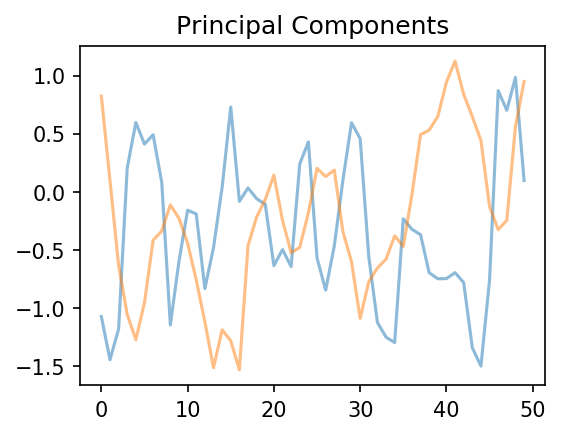

In [43]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(2):
    plt.plot(components[:50, j], alpha=0.5)
plt.title('Principal Components')
plt.show()

In [12]:
from factorgp import FactorGP
from inference import run_gibbs

In [18]:
n = 40
t = 50
q = 15
r = 2

In [21]:
dims = [n, t, q, r]
model = FactorGP(dims)
model.update_conditional_latent(Y)

In [54]:
import pickle
with open('results_final.pkl', 'wb') as fp:
    pickle.dump(results, fp)

In [59]:
with open('results_stable.pkl', 'rb') as fp:
    results = pickle.load(fp)

In [60]:
F_sample, loading_sample, variance_sample, theta_sample, traces_hist, mse_history = results

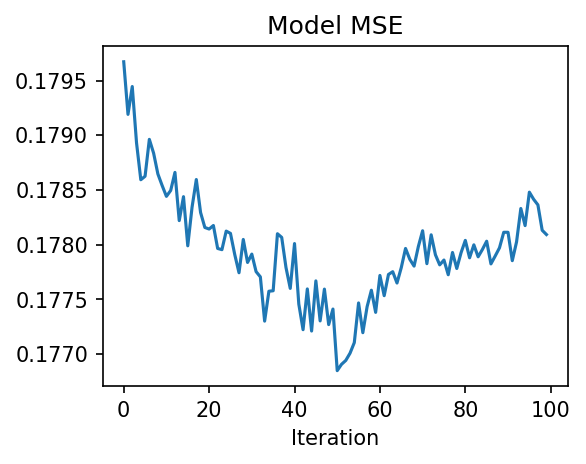

In [61]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(mse_history)
plt.title('Model MSE')
plt.xlabel('Iteration')
plt.show()

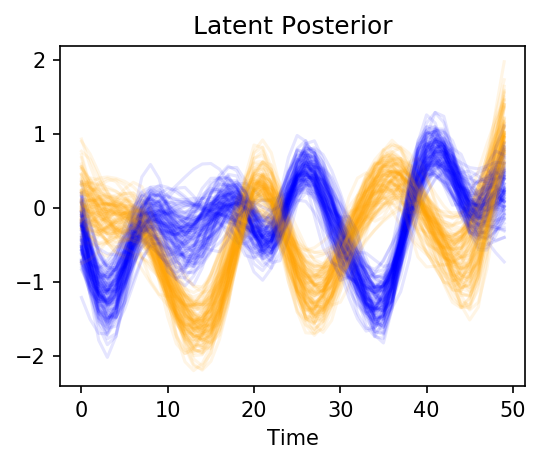

In [62]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(100):
    plt.plot(F_sample[i, :50, 0], color='orange', alpha=0.1)
    plt.plot(F_sample[i, :50, 1], color='blue', alpha=0.1)
plt.title('Latent Posterior')
plt.xlabel('Time')
plt.show()

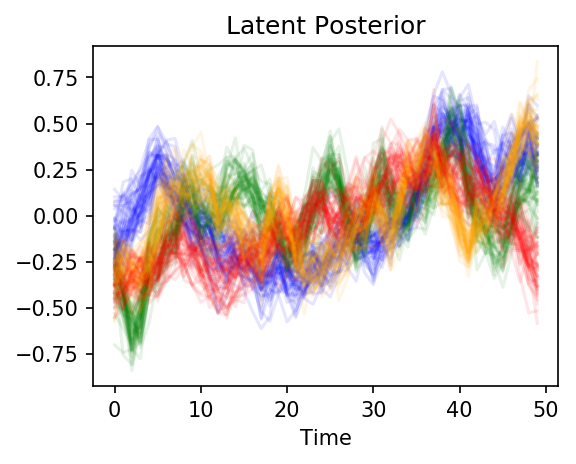

In [63]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(50, 100):
    factor1 = np.zeros((20, 50))
    factor2 = np.zeros((20, 50))
    for n in range(20):
        factor1[n, :] = F_sample[i, (n * 50):(n * 50 + 50), 0]
        factor2[n, :] = F_sample[i, (n * 50):(n * 50 + 50), 1]
    median_factor1 = np.median(factor1, axis=0)
    median_factor2 = np.median(factor2, axis=0)
    plt.plot(median_factor1, color='blue', alpha=0.1)
    plt.plot(median_factor2, color='green', alpha=0.1)
for i in range(50, 100):
    factor1 = np.zeros((20, 50))
    factor2 = np.zeros((20, 50))
    for n in range(20, 40):
        factor1[n - 20, :] = F_sample[i, (n * 50):(n * 50 + 50), 0]
        factor2[n - 20, :] = F_sample[i, (n * 50):(n * 50 + 50), 1]
    median_factor1 = np.median(factor1, axis=0)
    median_factor2 = np.median(factor2, axis=0)
    plt.plot(median_factor1, color='red', alpha=0.1)
    plt.plot(median_factor2, color='orange', alpha=0.1)
plt.title('Latent Posterior')
plt.xlabel('Time')
plt.show()

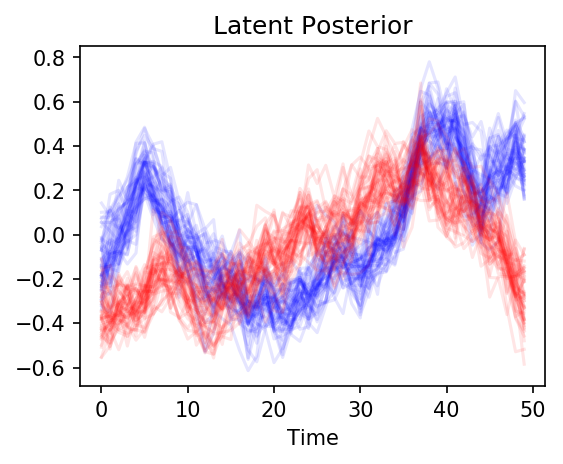

In [64]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(50, 100):
    factor1 = np.zeros((20, 50))
    for n in range(20):
        factor1[n, :] = F_sample[i, (n * 50):(n * 50 + 50), 0]
    median_factor1 = np.median(factor1, axis=0)
    plt.plot(median_factor1, color='blue', alpha=0.1)
for i in range(50, 100):
    factor1 = np.zeros((20, 50))
    for n in range(20, 40):
        factor1[n - 20, :] = F_sample[i, (n * 50):(n * 50 + 50), 0]
    median_factor1 = np.median(factor1, axis=0)
    plt.plot(median_factor1, color='red', alpha=0.1)
plt.title('Latent Posterior')
plt.xlabel('Time')
plt.show()

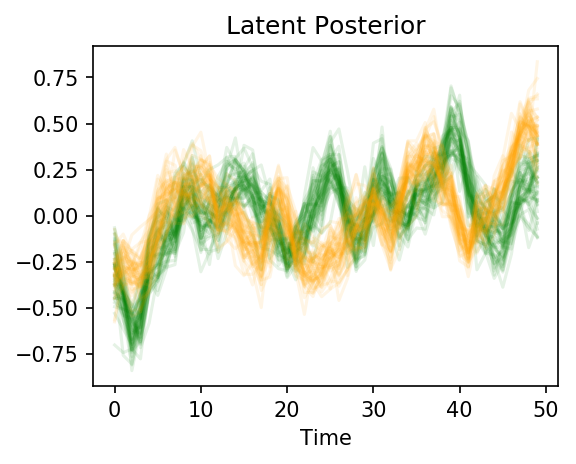

In [65]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(50, 100):
    factor2 = np.zeros((20, 50))
    for n in range(20):
        factor2[n, :] = F_sample[i, (n * 50):(n * 50 + 50), 1]
    median_factor2 = np.median(factor2, axis=0)
    plt.plot(median_factor2, color='green', alpha=0.1)
for i in range(50, 100):
    factor2 = np.zeros((20, 50))
    for n in range(20, 40):
        factor2[n - 20, :] = F_sample[i, (n * 50):(n * 50 + 50), 1]
    median_factor2 = np.median(factor2, axis=0)
    plt.plot(median_factor2, color='orange', alpha=0.1)
plt.title('Latent Posterior')
plt.xlabel('Time')
plt.show()

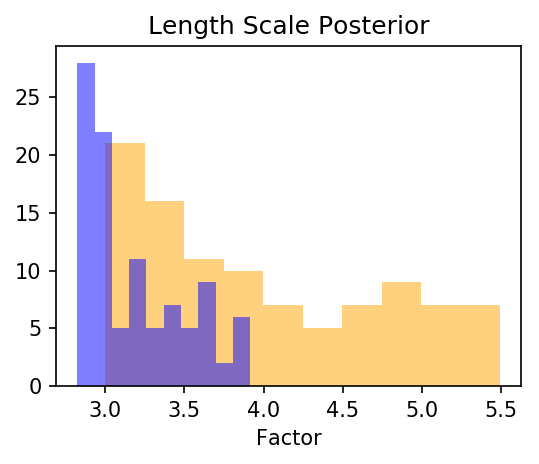

In [66]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.hist(theta_sample[:, 0], bins=10, alpha=0.5, color='orange')
plt.hist(theta_sample[:, 1], bins=10, alpha=0.5, color='blue')
plt.title('Length Scale Posterior')
plt.xlabel('Factor')
plt.show()

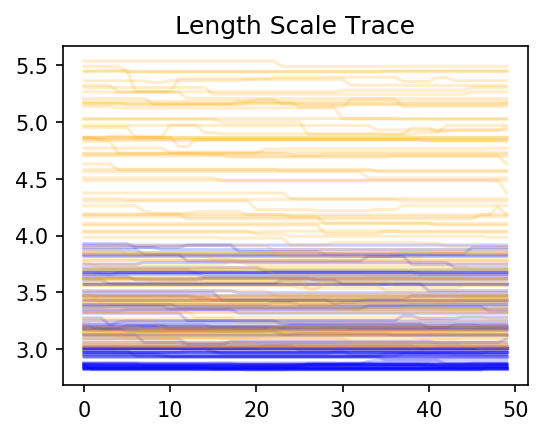

In [67]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for i in range(100):
    plt.plot(traces_hist[i, 0, :], alpha=0.2, color='orange')
    plt.plot(traces_hist[i, 1, :], alpha=0.2, color='blue')
plt.title('Length Scale Trace')
plt.show()